In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
import string
from nltk.corpus import stopwords
from nltk.classify import SklearnClassifier
from nltk.tokenize import sent_tokenize, word_tokenize
import time

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier 

In [29]:
df=pd.read_csv('Hotel_Reviews.csv')

In [30]:
df.shape

(515738, 17)

In [32]:
df.describe()

,Additional_Number_of_Scoring,Average_Score,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,lat,lng
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,512470.000000,512470.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.395077,49.442439,2.823803
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.637856,3.466325,4.579425
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000,41.328376,-0.369758
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000,48.214662,-0.143372
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000,51.499981,0.010607
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000,51.516288,4.834443
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233


In [33]:
df.describe(include=['O'])

,Hotel_Address,Review_Date,Hotel_Name,Reviewer_Nationality,Negative_Review,Positive_Review,Tags,days_since_review
count,515738,515738,515738,515738,515738,515738,515738,515738
unique,1493,731,1492,227,330011,412601,55242,731
top,163 Marsh Wall Docklands Tower Hamlets London ...,8/2/2017,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,No Positive,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days
freq,4789,2585,4789,245246,127890,35946,5101,2585


In [34]:
df.keys()

Index(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
       'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
       'Negative_Review', 'Review_Total_Negative_Word_Counts',
       'Total_Number_of_Reviews', 'Positive_Review',
       'Review_Total_Positive_Word_Counts',
       'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
       'days_since_review', 'lat', 'lng'],
      dtype='object')

In [35]:
hotels=df[['Hotel_Name','Average_Score','Total_Number_of_Reviews',\
           'Hotel_Address', 'Additional_Number_of_Scoring','lat', 'lng']].drop_duplicates().reset_index()
print(hotels.shape)
hotels.head(3)

(1494, 8)


,index,Hotel_Name,Average_Score,Total_Number_of_Reviews,Hotel_Address,Additional_Number_of_Scoring,lat,lng
0,0,Hotel Arena,7.7,1403,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,52.360576,4.915968
1,405,K K Hotel George,8.5,1831,1 15 Templeton Place Earl s Court Kensington a...,244,51.491888,-0.194971
2,971,Apex Temple Court Hotel,9.2,2619,1 2 Serjeant s Inn Fleet Street City of London...,639,51.513734,-0.108751


In [36]:
# Hotel address ---> Country ('Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria')
hotels['Country']=hotels['Hotel_Address'].apply(lambda x: x.split()[-1]).replace('Kingdom','UK')
hotels.Country.unique()

array(['Netherlands', 'UK', 'France', 'Spain', 'Italy', 'Austria'],
      dtype=object)

In [37]:
# Gets the most common nationality of reviews for each hotel
most_national=df[['Hotel_Name','Hotel_Address','Reviewer_Nationality']].groupby(['Hotel_Name','Hotel_Address']).agg(lambda x:x.value_counts().index[0])

In [38]:
# Create list from Tags and rank them by occurence
tags_rank=pd.Series(re.findall(r'[\']\s([\w\s]+)\s[\']',''.join(df.Tags))).value_counts()

In [39]:
# Correct day of the review into integer
df['days_since_review']=pd.to_numeric(df['days_since_review'].str.replace(r'[a-z]+', ""))

In [40]:
# DataFrames with Negative reviews and positive reviews given
neg_rev=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)
pos_rev=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)
neg_rev = neg_rev[neg_rev['Reviewer_Score']<5].reset_index().drop('index',1)
pos_rev = pos_rev[pos_rev['Reviewer_Score']>8].reset_index().drop('index',1)

In [43]:
# Takes review and gives back the clean list of words

#TokTok faster than word_tokenize
from nltk.tokenize import ToktokTokenizer
toktok = ToktokTokenizer()

# Stopwords, numbers and punctuation to remove
remove_punct_and_digits = dict([(ord(punct), ' ') for punct in string.punctuation + string.digits])
stopWords = set(stopwords.words('english'))


def word_cleaner(data):
    cleaned_word = data.lower().translate(remove_punct_and_digits)
    words = word_tokenize(cleaned_word)
    words = [toktok.tokenize(sent) for sent in sent_tokenize(cleaned_word)]
    wordsFiltered = []
    if not words:
        pass
    else:
        for w in words[0]:
            if w not in stopWords:
                wordsFiltered.append(w)
                end=time.time()
    return wordsFiltered


# Example
wordsFiltered = word_cleaner(neg_rev.Negative_Review[1])
print(neg_rev.Negative_Review[1])
print(wordsFiltered)

 My room was dirty and I was afraid to walk barefoot on the floor which looked as if it was not cleaned in weeks White furniture which looked nice in pictures was dirty too and the door looked like it was attacked by an angry dog My shower drain was clogged and the staff did not respond to my request to clean it On a day with heavy rainfall a pretty common occurrence in Amsterdam the roof in my room was leaking luckily not on the bed you could also see signs of earlier water damage I also saw insects running on the floor Overall the second floor of the property looked dirty and badly kept On top of all of this a repairman who came to fix something in a room next door at midnight was very noisy as were many of the guests I understand the challenges of running a hotel in an old building but this negligence is inconsistent with prices demanded by the hotel On the last night after I complained about water damage the night shift manager offered to move me to a different room but that offer 

In [44]:
# We take a small sample to speed up Learning
neg_red=neg_rev[:50000].copy()
pos_red=pos_rev[:50000].copy()

In [45]:
# Create set related to positive and negative review
def word_feats(words):
    return dict([(word, True) for word in words])
neg_set=[(word_feats(word_feats(word_cleaner(neg_red.loc[i,'Negative_Review']))), 0) for i in range(len(neg_red))]
pos_set=[(word_feats(word_feats(word_cleaner(pos_red.loc[i,'Positive_Review']))), 1) for i in range(len(pos_red))]

In [46]:
# Train the model and use CV to test accuracy

negcutoff = int(len(neg_set)*3/4)
poscutoff = int(len(pos_set)*3/4)
 
trainfeats = neg_set[:negcutoff] + pos_set[:poscutoff]
testfeats = neg_set[negcutoff:] + pos_set[poscutoff:]
print(len(trainfeats), len(testfeats))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print( 'accuracy:', nltk.classify.util.accuracy(classifier, testfeats))

53724 17908
accuracy: 0.8930645521554612


In [47]:
# Builds the dataframe of words with respective sentiment and score

cpdist = classifier._feature_probdist
word=[]
score=[]
sentiment=[]
for (fname, fval) in classifier.most_informative_features(100):
            def labelprob(l):
                return cpdist[l, fname].prob(fval)

            labels = sorted([l for l in classifier._labels
                             if fval in cpdist[l, fname].samples()],
                            key=labelprob)
            if len(labels) == 1:
                continue
            l0 = labels[0]
            l1 = labels[-1]
            if cpdist[l0, fname].prob(fval) == 0:
                ratio = 'INF'
            else:
                ratio = '%8.1f' % (cpdist[l1, fname].prob(fval) /
                                   cpdist[l0, fname].prob(fval))
            sentiment.append(int(l1))
            word.append(fname)
            score.append(float(ratio))

In [48]:
# Divides scores into negative and positive
word_scores=pd.DataFrame({'word':word,'sentiment':sentiment,'score':score})
neg_word_scores=word_scores[word_scores.sentiment==0]
pos_word_scores=word_scores[word_scores.sentiment==1]
display(word_scores[word_scores['sentiment']==1].head())
display(word_scores[word_scores['sentiment']==0].head())
neg_given=df[df.Negative_Review!='No Negative'].reset_index().drop('index',1)
pos_given=df[df.Positive_Review!='No Positive'].reset_index().drop('index',1)

,word,sentiment,score
7,superb,1,198.0
20,delicious,1,127.1
47,excellent,1,77.8
54,fab,1,72.0
56,beautifully,1,70.8


,word,sentiment,score
0,worst,0,929.9
1,rude,0,691.1
2,dirty,0,648.6
3,disgusting,0,361.3
4,terrible,0,302.3


In [49]:
# Sums positive and negative scores for a given review
def pos_sentiment_sum(review):
    pos=0
    asd=word_cleaner(review)
    set_w=set(pos_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            pos+=pos_word_scores[pos_word_scores['word']==word].score.iloc[0]
    
    return pos

def neg_sentiment_sum(review):
    neg=0
    asd=word_cleaner(review)
    set_w=set(neg_word_scores.word)-set(['no','negative','positive'])
    
    for word in asd:
        if word in set_w:
            neg+=neg_word_scores[neg_word_scores['word']==word].score.iloc[0]
    
    return neg

# TEST
display(neg_sentiment_sum(df.Negative_Review[6584]),\
        pos_sentiment_sum(df.Positive_Review[6584]))

0

77.8

In [51]:
# VERY SLOW! AROUND 45min for full database
# Produce the pos and neg colums in database

pos_col=[]
for i in range(len(df)):
    if df.Positive_Review[i]=='No Positive':
        pos_col.append(int(0))
    else:
        pos_col.append(pos_sentiment_sum(df.Positive_Review[i]))
df['pos_score']=pos_col

neg_col=[]
for i in range(len(df)):
    if df.Negative_Review[i]=='No Negative':
        neg_col.append(int(0))
    else:
        neg_col.append(neg_sentiment_sum(df.Negative_Review[i]))
df['neg_score']=neg_col

In [52]:
#df.to_csv('Hotel_Review_Sentiment_Analysis', index = False)
#df=pd.read_csv('Hotel_Review_Sentiment_Analysis.csv')

In [86]:
df.sort_values('pos_score',ascending=False).head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,pos_score,neg_score
84612,2 24 Kensington High St Kensington and Chelsea...,617,9/15/2015,8.8,Royal Garden Hotel,United Kingdom,The only recommendation I could make is impro...,62,2213,Staff were excellent Really on the ball and v...,32,2,8.8,"[' Leisure trip ', ' Couple ', ' King Room ', ...",688,51.502702,-0.188216,600.9,0.0
378214,Marina 19 21 08005 Barcelona Spain,219,7/17/2017,8.8,Hotel Arts Barcelona,United States of America,Property could use a small face lift The comm...,138,1350,I stayed three nights in a One bedroom Suite ...,186,1,8.8,"[' Leisure trip ', ' Family with young childre...",17,41.386542,2.196967,594.0,236.5
108745,22 Hertsmere Road Tower Hamlets London E14 4ED...,930,3/15/2016,8.9,London Marriott Hotel West India Quay,United Kingdom,No Negative,0,2836,Staff were superb Location superb perfectly s...,31,5,10.0,"[' Leisure trip ', ' Couple ', ' Deluxe King o...",506,51.507271,-0.021121,594.0,0.0


In [85]:
df.sort_values('neg_score',ascending=False).head(3)

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng,pos_score,neg_score
123742,26 28 Trebovir Rd Kensington and Chelsea Londo...,328,11/30/2015,7.5,Mayflower Hotel Apartments,Netherlands,We made our booking last minute on booking co...,363,2197,No Positive,0,2,2.5,"[' Business trip ', ' Couple ', ' Small Double...",612,51.491668,-0.194747,0.0,4427.7
201293,5 rue de Berri 8th arr 75008 Paris France,329,9/1/2016,8.1,Warwick Paris Former Warwick Champs Elysees,United Kingdom,We are usually traveling to Paris 2 3 times a...,256,1813,The only positive point of this hotel is loca...,40,1,4.2,"[' Leisure trip ', ' Family with young childre...",336,48.872202,2.303087,0.0,4357.8
171829,4 18 Harrington Gardens Kensington and Chelsea...,1444,6/14/2017,7.8,Millennium Gloucester Hotel London,Ireland,Our room was the worst room we have ever stay...,64,5726,Location to the underground was the only good...,14,5,4.2,"[' Leisure trip ', ' Group ', ' Standard Twin ...",50,51.493508,-0.183435,0.0,4144.4


In [95]:
# Lets have some fun reading the top 3 best and worst reviews! 
print('-----')
print('Negative nr.1')
print('-----')
print(df.sort_values('neg_score',ascending=False).reset_index().loc[0,'Negative_Review'])
print('-----')
print('Positive nr.1')
print('-----')
print(df.sort_values('pos_score',ascending=False).reset_index().loc[0,'Positive_Review'])

print('-----')
print('Negative nr.2')
print('-----')
print(df.sort_values('neg_score',ascending=False).reset_index().loc[1,'Negative_Review'])
print('-----')
print('Positive nr.2')
print('-----')
print(df.sort_values('pos_score',ascending=False).reset_index().loc[1,'Positive_Review'])

print('-----')
print('Negative nr.3')
print('-----')
print(df.sort_values('neg_score',ascending=False).reset_index().loc[2,'Negative_Review'])
print('-----')
print('Positive nr.3')
print('-----')
print(df.sort_values('pos_score',ascending=False).reset_index().loc[2,'Positive_Review'])

-----
Negative nr.1
-----
 We made our booking last minute on booking com When we arrived at the hotel they assigned us a room in the back of the building in the basement It didn t look anything like the pictures shown on the website That it was small was no problem for us we are familiar with the size of London hotel rooms however the dirt we didn t expect The window was blocked by a vacuum cleaner on the outside There was no fresh air in the room On top of the radiator which the bed was pushed against and was about 5 cm away from the pillows there was a thick layer of dust it obviously hadn t been cleaned in ages When we came up to reception to complain the staff was very rude and would not help us at all unless we paid 40 pounds extra for another room type and on top of that we would have to move rooms during our stay This was completely unacceptable to us since the room was dirty We decided we wanted to leave the hotel since the room was dirty and we felt uncomfortable by the treat

/Users/Paco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  
/Users/Paco/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


(array([6.8591e+04, 0.0000e+00, 5.9240e+03, 3.9560e+03, 4.2100e+02,
        5.3610e+03, 3.0800e+02, 4.7500e+02, 1.0520e+03, 1.2000e+02,
        1.8400e+02, 1.2000e+01, 9.6000e+01, 2.0000e+01, 1.4000e+01,
        2.3000e+01, 6.0000e+00, 4.0000e+00, 4.0000e+00, 7.0000e+00]),
 array([ 58.1 ,  85.24, 112.38, 139.52, 166.66, 193.8 , 220.94, 248.08,
        275.22, 302.36, 329.5 , 356.64, 383.78, 410.92, 438.06, 465.2 ,
        492.34, 519.48, 546.62, 573.76, 600.9 ]),
 <a list of 20 Patch objects>)

/Users/Paco/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


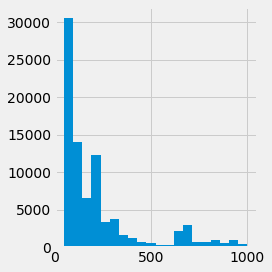

/Users/Paco/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


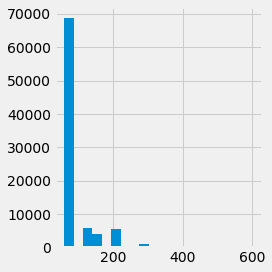

In [81]:
plt.figure(figsize=(4,4))
plt.hist(df[(df.neg_score>0)][(df.neg_score<1000)].neg_score,bins=20)
plt.figure(figsize=(4,4))
plt.hist(df[(df.pos_score>0)][(df.pos_score<1000)].pos_score,bins=20)

In [ ]:
# Reviews grouped by rate band
score_9=df[df.Reviewer_Score>9].copy()
score_4=df[df.Reviewer_Score<4].copy()
score_6=df[df.Reviewer_Score<7].copy()
score_7=df[(df.Reviewer_Score>7)&(df.Reviewer_Score<8)].copy()
score_8=df[(df.Reviewer_Score>8)&(df.Reviewer_Score<9)].copy()
print(score_6.shape)
print(score_7.shape)
print(score_8.shape)
print(score_9.shape)

/Users/Paco/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


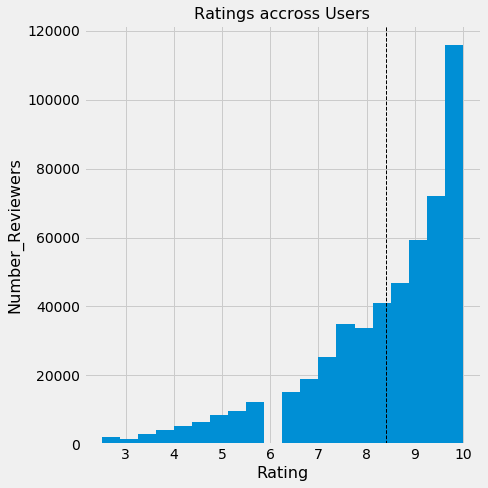

/Users/Paco/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


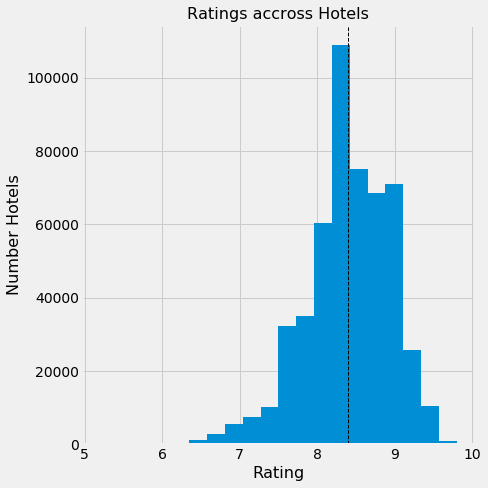

/Users/Paco/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


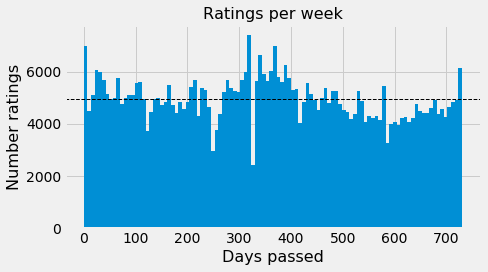

/Users/Paco/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


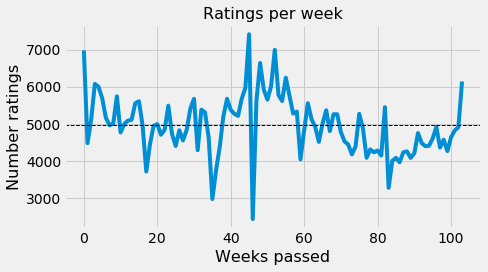

In [27]:
# Some plots

from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.style.use('fivethirtyeight')

plt.figure(figsize=(7,7))
plt.hist(df['Reviewer_Score'],bins=20)
plt.ylabel('Number_Reviewers',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Users',fontsize=16)
plt.axvline(df['Reviewer_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_user.png')

plt.figure(figsize=(7,7))
plt.hist(df['Average_Score'],bins=20)
plt.ylabel('Number Hotels',fontsize=16)
plt.xlabel('Rating',fontsize=16)
plt.title('Ratings accross Hotels',fontsize=16)
plt.axvline(df['Average_Score'].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_hotel.png')

plt.figure(figsize=(7,4))
week_bins=int(np.floor((max(df['days_since_review'])-min(df['days_since_review']))/7))
vals = plt.hist(df['days_since_review'],bins=week_bins);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Days passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week.png')

plt.figure(figsize=(7,4))
plt.plot(vals[0]);
plt.ylabel('Number ratings',fontsize=16)
plt.xlabel('Weeks passed',fontsize=16)
plt.title('Ratings per week',fontsize=16)
plt.axhline(vals[0].mean(), color='k', linestyle='dashed', linewidth=1)
plt.savefig('Ratings_week_plot.png')